# Finding balance between corrective and preventative maintenance using predictive maintenance

### Authors: Anant Jain, Viral Patel

# Dataset Information:

Dataset for our project can be summarised as follows:

* Machine features: Lifecycle data of machine categorised by model type and age of a machine
* Telemetry data: Operational data collected for various parameters such as voltage, rotation speed, pressure and vibrations using their respective sensors.
* Maintenance Data: Machine's repair history which is documented as regular maintenance checks or replacement of different components.
* Failure Data: Component's failure history and their time of replacement.

Here we should take into account of a fact that failure data may be contained in maintenance data which can be in the form of parts replacement log or special error codes. So, in such cases we can extract the failure data from the maintenance data. It may be possible that there may be some correlation of some other variables with failure history which can help us identify a pattern of instances of failures. This type of correlation is hugely dependent on respective business domains.

Example of similar cases where this type of data is used for prediction :
    
**Machine conditions and usage:** Cruise ship scheduling data, sensor data collected from turbine engines of aircrafts, elevators condition data, ATM operational data, Train's condition data, Car's engine data.
    
**Machine features:** Technical specification of each machine. e.g. In case of Car's data we need the build date,age,usage data of the type of engine. 

**Failure history:** In case of cruise ship, we need data such as arrival delay, departure delay, component failure history.In In case of wind turbine we need data such as gearbox failures, blade failures, Motor failures.

**Maintenance history:** In case of CNC machine headstock, tailstock, chuck and tool maintenance logs also PLC circuit maintenance logs can help in determining rate of replacements of components.

We consider two main type of data types in case of predictive maintenance which is static data type and temporal data type. Telemetry data, Maintenance data and Failure data can be considered as time series data since they are designated with the time when data is collected. This data can be collected from a range of sources which can be either manual data entry or  using observational sensors. On the other hand Machine features and their technical specifications is of type static since it doesn't change after being recorded.

# Step 1:  Data Ingestion and Exploratory Analysis

## Imports

In [5]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt

### Machines Dataset:

This dataset contains data about Machine Specification by model type and age of 1000 machines. 

It includes data about each machine's Machine ID, model type and age. 

In [6]:
machines = pd.read_csv('machines.csv', encoding='utf-8') 
machines.head()

machineID   model  age
0          1  model2   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model2    2

In [7]:
machines.describe()

machineID          age
count  1000.000000  1000.000000
mean    500.500000     9.862000
std     288.819436     6.092789
min       1.000000     0.000000
25%     250.750000     5.000000
50%     500.500000    10.000000
75%     750.250000    15.000000
max    1000.000000    20.000000

The following figure plots a histogram of the machines age colored by respective model type.

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


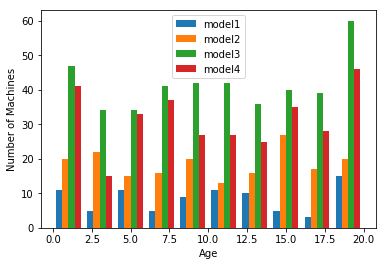

In [8]:
plt.hist([machines.loc[machines['model'] == 'model1', 'age'],
                       machines.loc[machines['model'] == 'model2', 'age'],
                       machines.loc[machines['model'] == 'model3', 'age'],
                       machines.loc[machines['model'] == 'model4', 'age']],
                       label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('Age')
plt.ylabel('Number of Machines')
plt.legend()
plt.show()

This figure shows lifecycle of each machine. The machine age is a important feature for analysis because various errors and failures of machines largely depend on it. We can see that for all age intervals the number of machines are always highest for model 3 followed by model 4, model 2 and model 1.


### Errors  Dataset:

The errors log contains list of errors which occured during operational state of machine which can also be stated as non breaking erros. Even though these errors can't be directly considered as failure reports but considering these error logs can highly help in our analysis since many errors can give us clear prediction about future failures. Here the datetime data is stored and rounded as an hourly rate.

In [9]:
errors = pd.read_csv('errors.csv', encoding='utf-8')
errors.head()

datetime  machineID errorID
0  2015-01-06 03:00:00          1  error3
1  2015-02-03 06:00:00          1  error4
2  2015-02-21 11:00:00          1  error1
3  2015-02-21 16:00:00          1  error2
4  2015-03-20 06:00:00          1  error1

In [10]:
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S") #string to date time format.V:Wasn't datetime already in the ymd-hms format??
errors.count()

datetime     11967
machineID    11967
errorID      11967
dtype: int64

The following histogram gives details about count of errors during considered time interval.

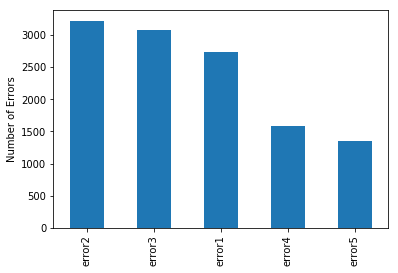

In [12]:
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Number of Errors')
plt.show()

Here as stated in the introduction about the dataset the error data is a time series data about the five different classes of error which occured throughout the year. Plotting the error log for each machine will not be much helpful here since there are total of 1000 machines. Thus, it will be very unconstructive to go through analysis of each and every machine.

### Maintenance Dataset:

Here Maintenance records contains both scheduleld and unscheduled maintenance checks. Schedule maintenance infers to periodic inspections or service of an equipment and unscheduled maintenance infers to immediate maintenance needs which may be due to performance degradataions and failures of machines. A failure record can be generated for both the cases of maintenance. Maintenance records can be used to calculate the component's life, the maintenance data is collected over years 2014 and 2015 instead of only the year of 2015 which is considered in other data.

In [13]:
maint = pd.read_csv('maint.csv', encoding='utf-8')
maint.head()

datetime  machineID   comp
0  2014-07-01 06:00:00          1  comp4
1  2014-09-14 06:00:00          1  comp1
2  2014-09-14 06:00:00          1  comp2
3  2014-11-13 06:00:00          1  comp3
4  2015-01-05 06:00:00          1  comp1

In [14]:
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint.count()

datetime     32592
machineID    32592
comp         32592
dtype: int64

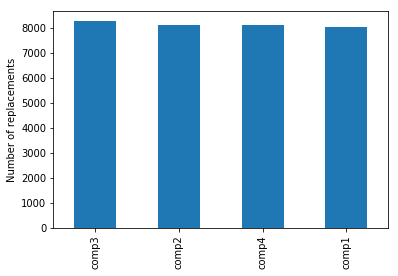

In [15]:
maint['comp'].value_counts().plot(kind='bar')
plt.ylabel('Number of replacements')
plt.show()

Above histogram shows analysis of component replacement history into four different categories over the years. From the graph it can be inferred that the components are replaced at similar rates.

Further analysis on this data can help us understand the underlying pattern about the lifetime of each component or the time history of replacements within each machine. Preprocessing of this data is discussed in our feature engineering section.

### Telemetry Dataset:

Telemetry is an automated communication system which measures and collects the data using sensors at remote server and transmits it to a recepient equipment for monitoring. Here the it contains real time data of voltage, pressure, vibration and rotation of a machine.  The final data is measured by averaging the data over an hour and stored in the telemetry history.

   It is important to calculate volatge data since many circuits are designed to handle only certain number of volts. Fluctuation in voltage can also be a reason for circuit failure. Also vibrational data and rotation data is a useful tool which is heavily used to measure tool's current condition which helps us to calculate remaining life span of that component.
    
   In any heavy machinary industry, operation cycle heavyly depends on maintaning right pressure in the machine. For exapmple, during any high speed operations such as cutting operation it is very important to maintain high pressure of cutting liquid which will help us reduce the wear and tear of the equipment and prevent breakdown of the system.

In [16]:
telemetry = pd.read_csv('telemetry.csv', encoding='utf-8')
telemetry.head()

datetime  machineID        volt      rotate    pressure  \
0  2015-01-01 06:00:00          1  151.919999  530.813578  101.788175   
1  2015-01-01 07:00:00          1  174.522001  535.523532  113.256009   
2  2015-01-01 08:00:00          1  146.912822  456.080746  107.786965   
3  2015-01-01 09:00:00          1  179.530561  503.469990  108.283817   
4  2015-01-01 10:00:00          1  180.544277  371.600611  107.553307   

   vibration  
0  49.604013  
1  41.515905  
2  42.099694  
3  37.847727  
4  41.467880

In [17]:
telemetry.describe()

machineID          volt        rotate      pressure     vibration
count  8.761000e+06  8.761000e+06  8.761000e+06  8.761000e+06  8.761000e+06
mean   5.005000e+02  1.707600e+02  4.466014e+02  1.008371e+02  4.034961e+01
std    2.886750e+02  1.550153e+01  5.261507e+01  1.099671e+01  5.337052e+00
min    1.000000e+00  8.778085e+01  1.021730e+02  4.862230e+01  1.435719e+01
25%    2.507500e+02  1.602964e+02  4.123434e+02  9.351999e+01  3.676380e+01
50%    5.005000e+02  1.705825e+02  4.475924e+02  1.004187e+02  4.021151e+01
75%    7.502500e+02  1.810046e+02  4.821119e+02  1.075293e+02  4.374465e+01
max    1.000000e+03  2.726818e+02  7.001998e+02  1.952711e+02  7.910749e+01

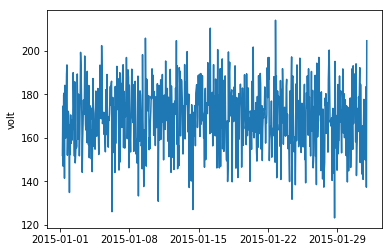

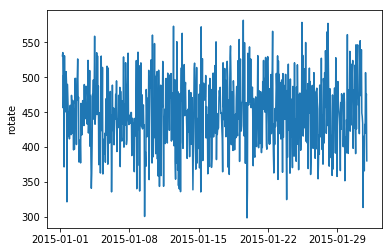

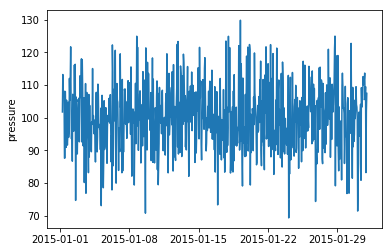

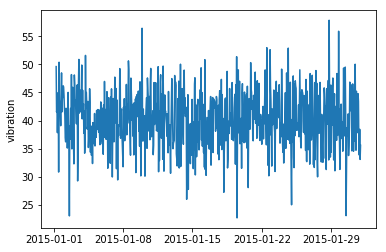

In [18]:
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")

df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'volt', 'rotate', 'pressure', 'vibration']]

plt.plot(df['datetime'], df['volt'])
plt.ylabel('volt')
plt.show()
plt.plot(df['datetime'], df['rotate'])
plt.ylabel('rotate')
plt.show()
plt.plot(df['datetime'], df['pressure'])
plt.ylabel('pressure')
plt.show()
plt.plot(df['datetime'], df['vibration'])
plt.ylabel('vibration')
plt.show()

Above figure shows telelmetry data of one month for one machine which is plotted separately for each type of sensors.

### Failures Dataset:

Failures data consists of information about component replacements with their replacement time stamp and machine ID. This dataset is built from component replacement history from maintenance dataset. Using this data we are creating machine learning labels for predicting failures.

In [19]:
failures = pd.read_csv('failures.csv', encoding='utf-8')
failures.head()

datetime  machineID failure
0  2015-02-04 06:00:00          1   comp3
1  2015-03-21 06:00:00          1   comp1
2  2015-04-05 06:00:00          1   comp4
3  2015-05-05 06:00:00          1   comp3
4  2015-05-20 06:00:00          1   comp2

In [20]:
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures.count()

datetime     6726
machineID    6726
failure      6726
dtype: int64

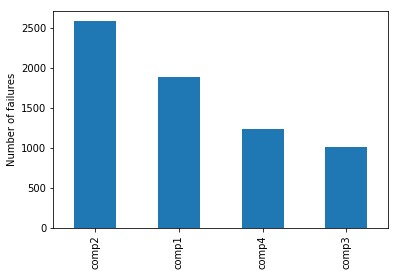

In [21]:
failures['failure'].value_counts().plot(kind='bar')
plt.ylabel('Number of failures')
plt.show()

The above histogram counts the number of failures related replacements which has been occured for each of the component type. 

# Step 2: Feature engineering 

In this step we will combine the different data sources to generate a single data set of features which will be used to summarise the machine's life cycle over a period of time. We will be generating a single record for each time unit mentioned in the final dataset. This records will contain various features and labels to generate a model which will be then provided to the machine learning algorithm to make predictions on the dataset.

In predictive maintenance we take history of condition of a machine at different times and predict the current health of the machine or component and use that to predict probability of failure in future. This problem can be  solved using time series classification methods. This is a binary classification problem using time series as predictor.

### Lag features

A time series data must be restructured as supervised learning problem. There are many different approaches to create feataures from time series data. we must choose the variable to be predicted and use feature engineering to construct all of the inputs that will be used to make predictions for future time steps First and foremost we divide the duration of data collection into time units in which each record points to a single point in time. The measurement unit choice can be considered arbitrary in this case. Time can be measured in months,days,hours, minutes etc. Unit choice is depended on it's use case domain.

Furthermore, If the time unit doesn't change frequently we can also use some statistical methods to generalize the pattern of change. For example, if we are calculating temperature change in a day then measurement of temperature every 5 seconds will be trivial for the overall pattern. Instead of that, we can consider the temperature change over a longer time interval which might explain patterns that contribute better for predicting the target variable.

After setting the frequency of observations, we are lookinng for the trends with different measurements over time, in order to predict performance degradation of machine, it's deterioration rate with time and connect all this with it's probability of failure. We are then creating features for these trends for each record using time lag window as a parameter over previous observations to determine machine's performance. Here lag window size is a hyperparameter which can be optimized using different methods such as cross - validation. We can also use a rolling window strategy where we calculate summary statistics such as mean over a window from previous observations.

For above mentioned summary statistics we can also use various other measures such as standard deviation, outliers, count of failures, cumulative sum of measures, minimum and maximum over the window size.

There is also another approach named tumbling window approach. Tumbling windows are a series of fixed-sized, non-overlapping and contiguous time intervals. For example, if we might have observations of every hours and then want to put them all together to create features aligned on a day or monthly basis.

For building features of our projects we use only a rolling window approach to demonstrate the overall process. We first align the data and then build features from those normalized observations in time.

## Transforming Telemetry features

From all of our datassets telemetry dataset is the largest time series data which has 8761000 hourly observation for 1000 machines.Since, There is not much variation observed for hourly observations, we transform the data by averaging sensor measures over 12 hour tumbling window. After this transformation, we are replacing the row data with tumbling window data, reducing it to 731000 observations. As a benefit of this approach it will reduce computation time required for feature engineering, modelling and labelling.

After reducing the data, we calculate our lag features by rolling aggregate measures such as mean, standard deviation, minimum, maximum to analyze the intermediate history of telemetry data.

The following code arranges the data to 12 hour observations and then calculates the mean and standard deviation for 12 and 24 hour time lags.

In [22]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=12).mean().resample('12H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_mean_12h = pd.concat(temp, axis=1)
telemetry_mean_12h.columns = [i + 'mean_12h' for i in fields]
telemetry_mean_12h.reset_index(inplace=True)
telemetry_mean_12h = telemetry_mean_12h.loc[-telemetry_mean_12h['voltmean_12h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=12).std().resample('12H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
telemetry_sd_12h = pd.concat(temp, axis=1)
telemetry_sd_12h.columns = [i + 'sd_12h' for i in fields]
telemetry_sd_12h.reset_index(inplace=True)
telemetry_sd_12h = telemetry_sd_12h.loc[-telemetry_sd_12h['voltsd_12h'].isnull()]

In [23]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).mean().resample('12H',
                                                                              closed='left',
                                                                              label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['voltmean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).std().resample('12H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['voltsd_24h'].isnull()]

In [24]:
telemetry_feat = pd.concat([telemetry_mean_12h,
                            telemetry_sd_12h.ix[:, 2:6],
                            telemetry_mean_24h.ix[:, 2:6],
                            telemetry_sd_24h.ix[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys

machineID   voltmean_12h  rotatemean_12h  pressuremean_12h  \
count  729000.000000  729000.000000   729000.000000     729000.000000   
mean      500.500000     170.759128      446.609585        100.836497   
std       288.675188       5.712698       21.216195          5.232821   
min         1.000000     148.918494      240.555739         86.499636   
25%       250.750000     167.228630      438.433805         98.141429   
50%       500.500000     170.244885      449.054520        100.145988   
75%       750.250000     173.387910      459.156515        102.233761   
max      1000.000000     225.106859      516.419586        166.739169   

       vibrationmean_12h     voltsd_12h   rotatesd_12h  pressuresd_12h  \
count      729000.000000  729000.000000  729000.000000   729000.000000   
mean           40.349084      14.707291      49.127996        9.854067   
std             2.292131       3.193583      10.710131        2.219156   
min            33.282624       3.132666      10.366925        2.231350   
25%            39.074348      12.470419      41.643277        8.325662   
50%            40.077281      14.575053      48.683220        9.735461   
75%            41.123582      16.797384      56.090431       11.234719   
max            63.894733      35.667974     118.183889       30.070135   

       vibrationsd_12h   voltmean_24h  rotatemean_24h  pressuremean_24h  \
count    729000.000000  729000.000000   729000.000000     729000.000000   
mean          4.915801     170.758742      446.610480        100.836500   
std           1.082040       4.699595       18.047447          4.644161   
min           1.069356     155.812721      265.786152         89.602349   
25%           4.163477     168.061923      441.580787         98.696793   
50%           4.865620     170.198761      449.203001        100.122834   
75%           5.609491     172.451111      456.385248        101.616973   
max          13.129524     224.651654      498.664658        162.459319   

       vibrationmean_24h     voltsd_24h   rotatesd_24h  pressuresd_24h  \
count      729000.000000  729000.000000  729000.000000   729000.000000   
mean           40.349053      14.918198      49.890548       10.037140   
std             1.984154       2.260502       7.690400        1.707467   
min            35.180444       6.210934      19.468158        3.756494   
25%            39.349888      13.361240      44.612521        8.915474   
50%            40.065254      14.843160      49.561593        9.913607   
75%            40.813814      16.393824      54.780142       10.968420   
max            62.664375      29.123530     113.941829       28.643578   

       vibrationsd_24h  
count    729000.000000  
mean          4.997416  
std           0.796001  
min           1.899192  
25%           4.459913  
50%           4.954711  
75%           5.479875  
max          12.025817

In [25]:
print(telemetry_feat.count())

machineID            729000
datetime             729000
voltmean_12h         729000
rotatemean_12h       729000
pressuremean_12h     729000
vibrationmean_12h    729000
voltsd_12h           729000
rotatesd_12h         729000
pressuresd_12h       729000
vibrationsd_12h      729000
voltmean_24h         729000
rotatemean_24h       729000
pressuremean_24h     729000
vibrationmean_24h    729000
voltsd_24h           729000
rotatesd_24h         729000
pressuresd_24h       729000
vibrationsd_24h      729000
dtype: int64


## Transforming Errors features

As error IDs are categorical values, it can't be averaged over time intervals like above. Instead of that, we are counting the number of errors for each time window.  

We transform and align the data by tumbling 12 hour window using a join with telemetry data.

In [26]:
error_ = pd.get_dummies(errors["errorID"])
error_count = pd.concat([errors["datetime"], 
                         errors["machineID"], 
                         error_], axis=1).dropna()
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()

error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

machineID        error1        error2        error3        error4  \
count  8.761000e+06  8.761000e+06  8.761000e+06  8.761000e+06  8.761000e+06   
mean   5.005000e+02  3.121790e-04  3.676521e-04  3.506449e-04  1.818286e-04   
std    2.886750e+02  1.766583e-02  1.917073e-02  1.872223e-02  1.348316e-02   
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.507500e+02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    5.005000e+02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    7.502500e+02  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+03  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

             error5  
count  8.761000e+06  
mean   1.536354e-04  
std    1.239402e-02  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    1.000000e+00

In [27]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).rolling(window=24).sum().resample('12H',
                                                                             closed='left',
                                                                             label='right').first().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_feat.dropna()
error_count.describe()

NameError: name 'error_feat' is not defined

## Calculating days since last replacement using maintenance dataset  

Determining lagging features from the maintenance data isn't a effortless calculation. It requires understanding of various machine domain expertise such as why this component has failed and what parameters can correlate better with it's failure pattern.  

It is important to consider the number of replacement components and also calculate the replacement time of each component. This is because of the fact that component's failures is highly related to it's life cycle. In most cases it is true that the longer the component is used, more prone it is to failure. 

The following code block addresses the problem and calculates the number of replaced components in given time and sorts the data as per recent date of change.

In [215]:
# create a column for each error type
comp_ = pd.get_dummies(maint["comp"])
comp_rep = pd.concat([maint["machineID"], 
                         maint["datetime"], 
                         comp_ ], axis=1).dropna()

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])
components = ['comp1', 'comp2', 'comp3', 'comp4']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
    
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

for comp in components:
    comp_rep[comp] = (comp_rep['datetime'] - pd.to_datetime(comp_rep[comp])).apply(lambda x: x / pd.Timedelta(days=1))
    
comp_rep.describe()


machineID         comp1         comp2         comp3         comp4
count  8.761000e+06  8.761000e+06  8.761000e+06  8.761000e+06  8.761000e+06
mean   5.005000e+02  5.337777e+01  5.294512e+01  5.159591e+01  5.308505e+01
std    2.886750e+02  5.922694e+01  5.939801e+01  5.733418e+01  5.960321e+01
min    1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    2.507500e+02  1.308333e+01  1.295833e+01  1.266667e+01  1.295833e+01
50%    5.005000e+02  3.220833e+01  3.175000e+01  3.091667e+01  3.179167e+01
75%    7.502500e+02  6.966667e+01  6.862500e+01  6.758333e+01  6.862500e+01
max    1.000000e+03  4.389583e+02  4.339583e+02  3.989583e+02  4.529583e+02

## A little change in machine features dataset

Machine dataset includes specification of each machine with it's age. These can be used without modification as it includes despcriptive information. But as model's description is of string type we are creating a sets of boolean and dummy variables to specify the model type. 

In [711]:
mod = pd.get_dummies(machines['model'])
machines['model'] = tuple(zip(mod.model1,mod.model2,mod.model3,mod.model4))

## Merging features datasets

Now, we merge the maintenance, error, machine and telemetry datasets into a integrated feature dataset. we can merge the data with simple join as most of the data is aligned with 12 hour observation period. 

In [712]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')

final_feat.describe()

machineID   voltmean_12h  rotatemean_12h  pressuremean_12h  \
count  729000.000000  729000.000000   729000.000000     729000.000000   
mean      500.500000     170.759128      446.609585        100.836497   
std       288.675188       5.712698       21.216195          5.232821   
min         1.000000     148.918494      240.555739         86.499636   
25%       250.750000     167.228630      438.433805         98.141429   
50%       500.500000     170.244885      449.054520        100.145988   
75%       750.250000     173.387910      459.156515        102.233761   
max      1000.000000     225.106859      516.419586        166.739169   

       vibrationmean_12h     voltsd_12h   rotatesd_12h  pressuresd_12h  \
count      729000.000000  729000.000000  729000.000000   729000.000000   
mean           40.349084      14.707291      49.127996        9.854067   
std             2.292131       3.193583      10.710131        2.219156   
min            33.282624       3.132666      10.366925        2.231350   
25%            39.074348      12.470419      41.643277        8.325662   
50%            40.077281      14.575053      48.683220        9.735461   
75%            41.123582      16.797384      56.090431       11.234719   
max            63.894733      35.667974     118.183889       30.070135   

       vibrationsd_12h   voltmean_24h      ...          error1count  \
count    729000.000000  729000.000000      ...        729000.000000   
mean          4.915801     170.758742      ...             0.007494   
std           1.082040       4.699595      ...             0.086480   
min           1.069356     155.812721      ...             0.000000   
25%           4.163477     168.061923      ...             0.000000   
50%           4.865620     170.198761      ...             0.000000   
75%           5.609491     172.451111      ...             0.000000   
max          13.129524     224.651654      ...             2.000000   

         error2count    error3count    error4count    error5count  \
count  729000.000000  729000.000000  729000.000000  729000.000000   
mean        0.008826       0.008421       0.004364       0.003690   
std         0.093721       0.091545       0.066017       0.060633   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         2.000000       2.000000       2.000000       1.000000   

               comp1          comp2          comp3          comp4  \
count  728000.000000  728000.000000  728000.000000  728000.000000   
mean       53.257865      52.820198      51.466714      52.957393   
std        59.152141      59.317405      57.241221      59.517514   
min         0.250000       0.250000       0.250000       0.250000   
25%        13.250000      12.750000      12.750000      12.750000   
50%        32.250000      31.750000      30.750000      31.750000   
75%        69.250000      68.250000      67.250000      68.250000   
max       438.750000     433.750000     398.750000     452.750000   

                 age  
count  729000.000000  
mean        9.862000  
std         6.089746  
min         0.000000  
25%         5.000000  
50%        10.000000  
75%        15.000000  
max        20.000000  

[8 rows x 27 columns]

# Label construction:

In a typical classification problem we just define a boolean labels which can be either true vs false or win vs lose etc. To train the model, the model requires data from both the classes. In our case, to predict failures the model reuires the time series data which leads upto the failures of machines as well as the exaples of healthy operational periods of the machine. In our example, the classification will be between operational condition of machine which is healthy vs failed.

Once we complete the classification between healthy vs failure, we need to do some additional calculation. We will only be able to gain advantage of our machine learning algorithm when we can give a notication for the upcoming problem in a machine to prevent the breakdown of a machine. In order to build a model for that we make modification in the label construction. We change label definition of _failure event_ to a longer window which indicates _failure duration _. Again, the duration of this warning window is highly dependent on the business application. For example, In order to prevent runway boiler accidents (which occurs when heating unit reaches an exceedingly high temperature and pressure and doesn't shut off after that) the warning window should be kept longer. In such cases, time is a critical factor here which can help us save many lives. It is upto the company to decide whether information about failures will occur in next 24 to 48 hours is enough time to prevent it from happening.  

To reconstruct the failure to about to fail we label all observations within failure warning window as failed. Now we are estimating the probability of failure within this window.

Now we are interested in estimating the probability of failure of a machine in next seven days due to certain component failure named component 1,2,3 or 4. 

A categorical feature is created to define as label of failure. For example, All the records which are within 24 hour window before a failure of component 3 are labelled as failure = "comp3", and so on for components 1,2,4. Also the records which are not within seven days of a component failure are labelled as failure = "none"

The following code aligns the failure data to 12 hour observations.

In [713]:
failures['datetime'] = failures['datetime'].apply(lambda x: x.replace(hour=12))

labeled_features = final_feat.merge(failures, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features['failure'] = labeled_features['failure'].fillna('none')
labeled_features = labeled_features.fillna(0.0)
labeled_features.head()



machineID            datetime  voltmean_12h  rotatemean_12h  \
0          1 2015-01-02 12:00:00    167.377318      452.034833   
1          1 2015-01-03 00:00:00    167.502723      439.043536   
2          1 2015-01-03 12:00:00    162.852984      454.954241   
3          1 2015-01-04 00:00:00    175.831151      439.725525   
4          1 2015-01-04 12:00:00    167.286938      464.254230   

   pressuremean_12h  vibrationmean_12h  voltsd_12h  rotatesd_12h  \
0         99.964799          44.363301   15.565892     51.456182   
1        103.082577          39.768041   12.445835     26.860609   
2         99.840514          38.193216   12.448401     49.565265   
3        102.623669          40.852524   16.095546     29.331879   
4         96.945432          44.278333   11.453878     31.113321   

   pressuresd_12h  vibrationsd_12h   ...     error3count  error4count  \
0        7.133463         3.075716   ...             0.0          0.0   
1        9.973548         3.290649   ...             0.0          0.0   
2       10.624707         6.560103   ...             0.0          0.0   
3       11.818502         6.141972   ...             0.0          0.0   
4       10.282070         3.329338   ...             0.0          0.0   

   error5count   comp1   comp2  comp3   comp4         model  age  failure  
0          0.0  110.25  110.25  50.25  185.25  (0, 1, 0, 0)   18     none  
1          0.0  110.75  110.75  50.75  185.75  (0, 1, 0, 0)   18     none  
2          0.0  111.25  111.25  51.25  186.25  (0, 1, 0, 0)   18     none  
3          0.0  111.75  111.75  51.75  186.75  (0, 1, 0, 0)   18     none  
4          0.0  112.25  112.25  52.25  187.25  (0, 1, 0, 0)   18     none  

[5 rows x 30 columns]

In [509]:
# To get the frequency of each component failure 
labeled_features['failure'].value_counts()

none     678103
comp2     19845
comp1     15068
comp4      8955
comp3      7389
Name: failure, dtype: int64

In the above mentioned code we are counting failure classes in the feature data after assigning the component failure records which helps us in validating the results.

# Step 3: Model Building

# Prepare the Training/Testing data

A general method in machine learning is to train your model with different model parameters and test it on the data which has not been used in training of the model. This kind of evaluation method requires partitioning the data into different sets. Typically, 70% of the data is used for training and 30% is used for testing.

Generally random splitting is used, but here if we use that approach we will not be able to consider the correlation between these time series observations. For predictive maintenance domain, a time-dependent split is more useful for predicting underlying patterns.For this type of analysis, a single point in time is chosen and then the model is trained on examples upto that point in time and tested on the examples after that point. In orer to account for the failure pattern, we haven't labelled feature records within the split point since it can be categorised as unobserved data.

In the following code blocks, we splitted data at a single point after 9 months of operation in the year 2015.

### Editing Table
1. We do not want any null values in our table, so we check if there are any.
2. Then we plot the correlation between our external factors. Red means high correlation while blue means low correlation. We want low correlation because if we have multiple columns with high correlation, it's repetitive in the machine learning model. 

### Checking for null values

In [510]:
labeled_features.isnull().values.any() 

False

### Splitting the data

In [716]:
train_y = labeled_features.loc[labeled_features['datetime'] <= pd.to_datetime('2015-09-30 12:00:00'), 'failure']
train_x = labeled_features.loc[labeled_features['datetime'] <= pd.to_datetime('2015-09-30 12:00:00')].drop(['datetime',
                                                                                                        'machineID',
                                                                                                            'model',
                                                                                                        'failure'], 1)
test_y = labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00'), 'failure']
test_x = labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')].drop(['datetime',
                                                                                                       'machineID',
                                                                                                             'model',
                                                                                                       'failure'], 1)

# Classification models

An important thing to consider while classification is the uneven distribution of data for different classes. In our example, the machine failures are usually a rare occrences compared to instances where machine is categorized in healthy condition. 
This type of pattern is actually helpful for businesses but it can cause imbalance in label distribution. This leads to poor prediction as algorithm tends to classify majority class examples at the expense of minority class. Total misclassification error will be much less because majority of class is labeled correctly which leads to lower precision rate with high accuracy.
This type of misclassification can create problems where cost of false alarm is very large. To overcome this problem, sampling techniques such as oversampling of minority examples can be helpful to consider. These methods are not covered in this project because of correlation of data with time. Instead of that we are calculating evaluation metrics for determining precision level along with accuracy.

We have build and compared four different classification models:

 - **Random Forest Classifier**: Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. A random forest is an ensemble of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.
 
 - **Naive Bayes Classifier**: Naive Bayes Classifier is based on the bayesian theorem and is suited when the dimensionality of inputs is very high. In naive bayes classifier we assume that samples are independent and all features are given the same weights to classify an outcome. Here each distribution is assumed to have one dimensional distribution which helps in reducing the dimensionality problem. Despite it's simple architecture naive Bayes classifiers works really well in real world situations and that is the reason behind choosing this method.
 
 - **Gradient Boosting Classifier**: Like other boosting methods, gradient boosting combines weak "learners" into a single strong learner in an iterative fashion, typically decision trees. GBDT training generally takes longer because of the fact that trees are built sequentially. However, benchmark results have shown GBDT are better learners than Random Forests. 
 
 - **Neural Network Classifier**: Neural network algorithm is based on the complex network of neurons in our brain. They process single record at a time and learns from comparing their classification with the actual classification of the record. The errors from the initial classification is then fed back to the network which is used to modify the algorithm for next iterations.
 
 


## Random Forest Classifier

In [445]:
from sklearn.ensemble import RandomForestClassifier

In [539]:
%%time
model = RandomForestClassifier( max_depth=15, 
                                criterion="gini",
                                # Number of trees to train (>= 1)
                                n_estimators=50, 
                                # The number of features to consider for splits at each tree node. 
                                # Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].
                                max_features ="sqrt")
model.fit(train_x, train_y)

#how many number of folds do we have??
#folds are the subsamples that are used to train and validate our model.
#what is max features equals to sqrt??


Wall time: 2min 18s


In order to evaluate this model, we compare the actual failures listed in the test data with the predicted component failures over the test dataset. Since we haven't trained the model on the test data the test data simulates the available future data. Therefore evaluation can be generalized to how the model can perform in real time. 

In [541]:
rfctest = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')])
rfctest['predicted_failure'] = model.predict(test_x)

In [542]:
from sklearn.metrics import confusion_matrix
confuse = pd.crosstab(rfctest['failure'], rfctest['predicted_failure'])
confuse

predicted_failure  comp1  comp2  comp3  comp4    none
failure                                              
comp1               1341     26      1      9    2556
comp2                 18   2018      5      6    3189
comp3                  8     18    583      4    1264
comp4                 14     20      2    946    1385
none                  61     91     10     32  172472

In [543]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['comp1'][0]+confuse['comp2'][1]+confuse['comp3'][2]+confuse['comp4'][3]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['comp1', 'comp2','comp3','comp4']])) - tp

# True negatives 
tn = confuse['none'][4]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['none']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['none','comp1', 'comp2','comp3','comp4']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))

Accuracy = 0.953144
Precision = 0.937656
Recall = 0.368017
F1 = 0.528575


We have calculated confusion matrix which lists predicted failure in column and actual component failure in rows. Label 0 means there is no component failure. labels 1 to 4 showws compnent failures in respective components. 

The confusion matrix lists each true component failure in rows and the predicted value in columns. Labels numbered 0.0 corresponds to no component failures. Labels numbered 1.0 through 4.0 correspond to failures in one of the four components in the machine. As an example, the third number in the top row indicates how many days we predicted component 2 would fail, when no components actually did fail. The second number in the second row, indicates how many days we correctly predicted a component 1 failure within the next 7 days.

The diagonal values in confusion matrix shows accurately classified component failures. Numbers above the diagonals indicate inaccurately classified failures when in reality a failure hasn't occured. Numbers below the diagonal indicates incorrect prediction of non-failure when a failure has occured in reality.

For simplification of evaluation of confusion matrix, we have reduced the results in some performance statistic. This summary statistic can be different depending upon the problem domain.

- **Accuracy**: Accuracy is a measure of how correctly we have predicted the labeled data. But, again when there is a class imbalance this measure becomes biased towards the class with more number of data. Here in our example non-failure class has more number of data then failure class.

Due to this we look at some other statistics as mentioned below:
Here positive samples indicates a failure of a machine.

- **Precision**: Precision is used to determine how well the model classifies the truly positive samples. 
 Precision depends on falsely classifying negative days as positive.

- **Recall**: Recall is used to measure how well the model can find the positive samples.  
Recall depends on falsely classifying positive days as negative.

- **F1**: F1 is calculated using both precision and recall. F1 score is the harmonic average of precision and recall. F1 score of 1 corresponds to perfect precision and 0 corresponds to the worst performance.

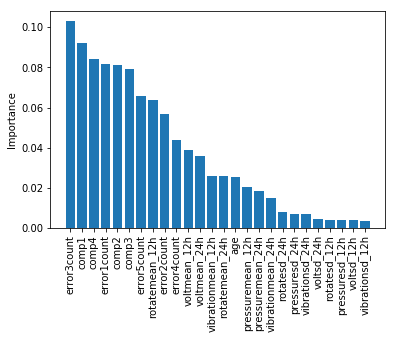

In [544]:
#Below, we plot the feature importances in the trained model
import operator

labels, importances = zip(*sorted(zip(test_x.columns, model.feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')
plt.show()

## Naive Bayes Model

In [545]:
from sklearn.naive_bayes import GaussianNB

In [721]:
%%time
model = GaussianNB()
model.fit(train_x, train_y)

Wall time: 951 ms


In [722]:
gnbtest['predicted_failure'] = model.predict(test_x)

In [724]:
confuse = pd.crosstab(gnbtest['failure'], gnbtest['predicted_failure'])
confuse

predicted_failure  comp1  comp2  comp3  comp4    none
failure                                              
comp1               1129     93    100     75    2536
comp2                 94   1664    135     87    3256
comp3                 21     32    780      9    1035
comp4                 31     69     50    863    1354
none                2745   3653   4737   2787  158744

In [549]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['comp1'][0]+confuse['comp2'][1]+confuse['comp3'][2]+confuse['comp4'][3]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['comp1', 'comp2','comp3','comp4']])) - tp

# True negatives 
tn = confuse['none'][4]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['none']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['none','comp1', 'comp2','comp3','comp4']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))

Accuracy = 0.876939
Precision = 0.231597
Recall = 0.351589
F1 = 0.279248


## Gradient Boosting Classifier

In [725]:
from sklearn.ensemble import GradientBoostingClassifier

In [726]:
%%time
model = GradientBoostingClassifier()
model.fit(train_x, train_y)

Wall time: 13min 2s


In [727]:
gbctest = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')])
gbctest['predicted_failure'] = model.predict(test_x)

In [728]:
confuse = pd.crosstab(gbctest['failure'], gbctest['predicted_failure'])
confuse

predicted_failure  comp1  comp2  comp3  comp4    none
failure                                              
comp1               1530     52     11     37    2303
comp2                 35   2107     19     23    3052
comp3                 10     20    737      8    1102
comp4                 12     24      6   1038    1287
none                 184    175     68     96  172143

In [729]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['comp1'][0]+confuse['comp2'][1]+confuse['comp3'][2]+confuse['comp4'][3]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['comp1', 'comp2','comp3','comp4']])) - tp

# True negatives 
tn = confuse['none'][4]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['none']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['none','comp1', 'comp2','comp3','comp4']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))

Accuracy = 0.954191
Precision = 0.874031
Recall = 0.411371
F1 = 0.559438


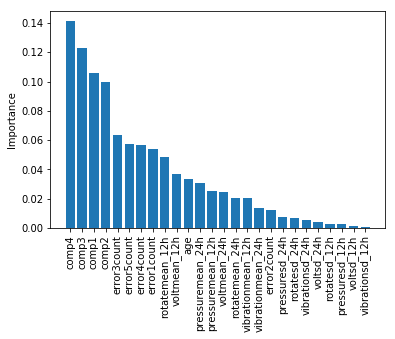

In [730]:
#Below, we plot the feature importances in the trained model

labels, importances = zip(*sorted(zip(test_x.columns, model.feature_importances_),
                                  reverse=True,
                                  key=operator.itemgetter(1)))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')
plt.show()

## Neural Network Model

In [671]:
from keras.models import Sequential #neural network for a sequence of layers
from keras.layers import Dense #Standard neural network layer
from keras.layers import Activation #Non-linear functions in the neural network to make it non-linear.

In [674]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
# encode class values as integers
enc = LabelEncoder()
enc.fit(train_y)
train_y = enc.transform(train_y)
# convert integers to dummy variables (i.e. one hot encoded)
train_y = np_utils.to_categorical(train_y)

In [675]:
model = Sequential()
model.add(Dense(12, input_dim=26, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

In [676]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [677]:
%%time
model.fit(train_x, train_y, epochs=100)

Epoch 1/10
543281/543281 [==============================] - 20s 36us/step - loss: 0.5396 - acc: 0.9284
Epoch 2/10
543281/543281 [==============================] - 21s 39us/step - loss: 0.3336 - acc: 0.9303
Epoch 3/10
543281/543281 [==============================] - 20s 37us/step - loss: 0.3294 - acc: 0.9303
Epoch 4/10
543281/543281 [==============================] - 21s 39us/step - loss: 0.3262 - acc: 0.9303
Epoch 5/10
543281/543281 [==============================] - 18s 34us/step - loss: 0.3237 - acc: 0.9303
Epoch 6/10
543281/543281 [==============================] - 18s 33us/step - loss: 0.3190 - acc: 0.9303
Epoch 7/10
543281/543281 [==============================] - 17s 32us/step - loss: 0.2925 - acc: 0.9340
Epoch 8/10
543281/543281 [==============================] - 17s 32us/step - loss: 0.2826 - acc: 0.9347
Epoch 9/10
543281/543281 [==============================] - 22s 40us/step - loss: 0.2807 - acc: 0.9349
Epoch 10/10
543281/543281 [==============================] - 20s 36us/ste

In [667]:
nntest = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] >= pd.to_datetime('2015-10-01 00:00:00')])
pred = model.predict(test_x)
pred = np.argmax(pred, axis=1) 
nntest['predicted_failure'] = enc.inverse_transform(pred)

D:\Workspace\Python\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [668]:
confuse = pd.crosstab(nntest['failure'], nntest['predicted_failure'])
confuse

predicted_failure    none
failure                  
comp1                3933
comp2                5236
comp3                1877
comp4                2367
none               172666